In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
 
from mlprecip_utils import *
from mlprecip_models import *
from mlprecip_datasets import *
from mlprecip_xai import *
from mlprecip_plot import *

import mlprecip_datasets

import warnings

Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

In [2]:
warnings.filterwarnings("ignore")

### Set Some Variables

In [3]:
varname='precip'
#model_types=['logmodel_med'] #,'nnmodel_med']
model_types=['nnmodel_med']
winter=[12,1,2]
summer=[6,7,8]
nmodels=100

### Read in Target and Features for Training and Validation

In [4]:
ds_features_tval=xr.open_dataset('../data/fnn_test/features_trainval.nc')
ds_target_tval=xr.open_dataset('../data/fnn_test/target_trainval.nc')

In [5]:
indices_dict=init_predictors_dict()

### Main Program

Summer
nnmodel_med
Upper Cat:  1748
Lower Cat:  1748
Check Features and Target Dimensions
Features (X):  (3496, 10)
Target (Y):  (3496, 2)
Training Size:  3146
Validation Size:  350
Training set accuracy score: 0.5235219326909947
Validation set accuracy score: 0.5114285685122013
Validation ROC AUC score: 0.6126880018093407
Training set accuracy score: 0.503178638476554
Validation set accuracy score: 0.6371428625924247
Validation ROC AUC score: 0.6085039013909306
Training set accuracy score: 0.5282898925372694
Validation set accuracy score: 0.5371428589735713
Validation ROC AUC score: 0.5749557088469222
Training set accuracy score: 0.5000000005423341
Validation set accuracy score: 0.5485714301466942
Validation ROC AUC score: 0.6318368577782804
Training set accuracy score: 0.5089001900315739
Validation set accuracy score: 0.537142853651728
Validation ROC AUC score: 0.5903351049794565
Training set accuracy score: 0.4952320411720817
Validation set accuracy score: 0.5942857222897666
Validat

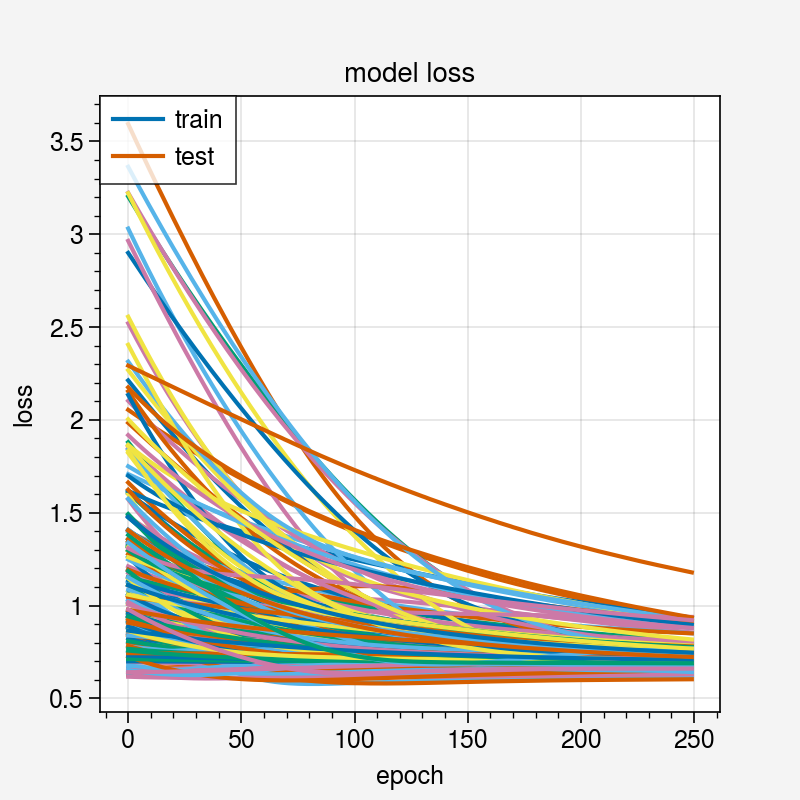

In [6]:
# Loop over seasons
#for seas,slabel,seas_abbrv in zip([winter,summer],['Winter','Summer'],['DJF','JJA']):
for seas,slabel,seas_abbrv in zip([summer],['Summer'],['JJA']):

    print(slabel)
    
    # Get list of predictors for this season
    pred_list=[]
    for d in indices_dict:
        if seas_abbrv in d['seas']:
            pred_list.append(d['name'])
    
    # Select season from target precip anomalies
    ds_t=ds_target_tval.sel(time=ds_target_tval['time.month'].isin(seas))
    ds_f=ds_features_tval.sel(time=ds_features_tval['time.month'].isin(seas))
    
    # Make sure we have the same times for target and features
    ds_t,ds_f=xr.align(ds_t,ds_f.fillna(0.0),join='inner')
    
    # Subtract the median to ensure data is centered and classes are equal
    median=np.percentile(ds_t[varname],50)
    ds_t[varname]=ds_t[varname]-median
    
    # Call Function to train models
    for m_function in model_types:
        print(m_function)
        fname='../data/fnn_test/seus.median.'+seas_abbrv+'.'+m_function
        ofname='../data/fnn_test/model_output.'+seas_abbrv+'.'+m_function
        trainIndexModels(m_function,ds_f,ds_t,
                         varname,nmodels,fname=fname,ofname=ofname)